In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import LSTM, Dense
from keras.layers import GRU 
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [68]:
exchange_data = pd.read_csv('GBPUSD-4HOUR.csv')
exchange_data.head()


,time,open,high,low,close,Volume,Volume MA
0,2009-12-31T22:00:00Z,1.617570,1.617570,1.615630,1.615630,8,NaN
1,2010-01-03T22:00:00Z,1.611220,1.615290,1.609180,1.609230,4115,NaN
2,2010-01-04T02:00:00Z,1.609230,1.612080,1.607350,1.609630,2782,NaN
3,2010-01-04T06:00:00Z,1.609630,1.621375,1.605795,1.620535,7412,NaN
4,2010-01-04T10:00:00Z,1.620535,1.624185,1.613925,1.616265,8100,NaN


In [69]:
exchange_data["time"] = pd.to_datetime(exchange_data["time"])
ind_exchange_data = exchange_data.set_index(["time"], drop=True)

In [70]:
ind_exchange_data.head()
print(len(ind_exchange_data))

20438


In [71]:
data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=False)

cut_off_date = pd.Timestamp('12-10-20')
data_frame = data_frame.loc[:cut_off_date]
data_frame.tail()




/var/folders/qs/tq01j0l577ddz8gg_tnvhl6m0000gn/T/ipykernel_30485/3679277369.py:4: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  data_frame = data_frame.loc[:cut_off_date]


,open,low,high,close,Volume MA,Volume
time,,,,,,
2020-12-09 06:00:00+00:00,1.33762,1.33621,1.34494,1.34468,10239.45,9840
2020-12-09 10:00:00+00:00,1.34468,1.34384,1.34783,1.34600,10708.35,11843
2020-12-09 14:00:00+00:00,1.34600,1.33554,1.34607,1.33713,10822.95,15903
2020-12-09 18:00:00+00:00,1.33713,1.33615,1.34071,1.34066,10321.05,6266
2020-12-09 22:00:00+00:00,1.34066,1.33225,1.34135,1.33687,9680.10,4823


<AxesSubplot: xlabel='time'>

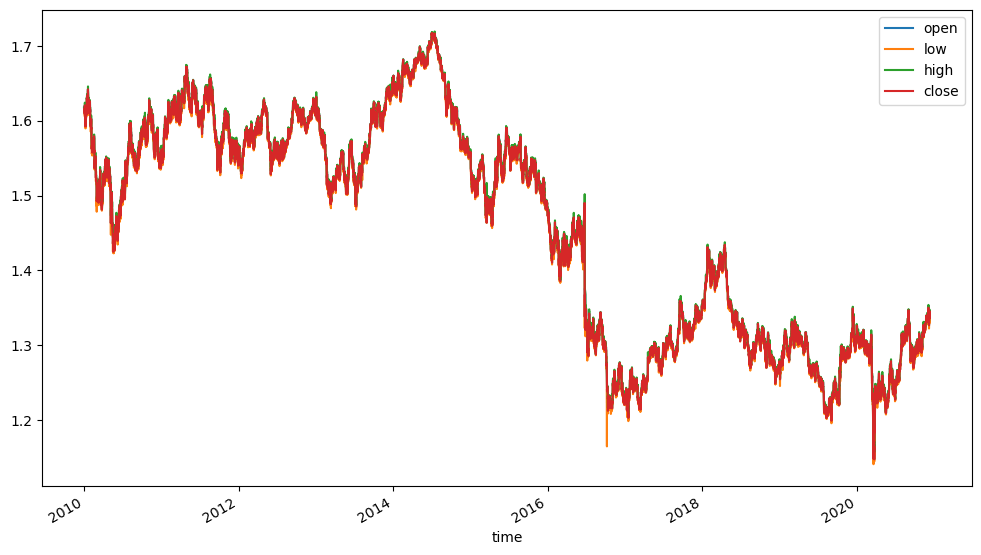

In [72]:
df = data_frame[["open", "low", "high", "close"]]

#plotting dataset to visualize the pattern of prices over the years

df.plot(kind='line',figsize=(12,7))

In [73]:
diff = df.index.values[-1] - df.index.values[0]
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 2010 to %d"%(2010 + int(0.8*years)))

Total data: 10 years
80 percent data = 2010 to 2018


In [74]:
df.describe()

,open,low,high,close
count,17021.000000,17021.000000,17021.000000,17021.000000
mean,1.456573,1.454315,1.458801,1.456559
std,0.146887,0.146908,0.146879,0.146886
min,1.147640,1.141160,1.154900,1.147640
25%,1.304935,1.303240,1.306990,1.304935
50%,1.509925,1.507450,1.511970,1.509875
75%,1.583130,1.580985,1.585495,1.583105
max,1.717000,1.715970,1.719220,1.717000


In [75]:
#deduce where the number where the partition should be made 

adjust_data_frame = np.array(data_frame)
x = int(len(data_frame))
split_length = int(x * 0.8)
#You need find the data where the training and testing will be split
split_date = data_frame.index[split_length]




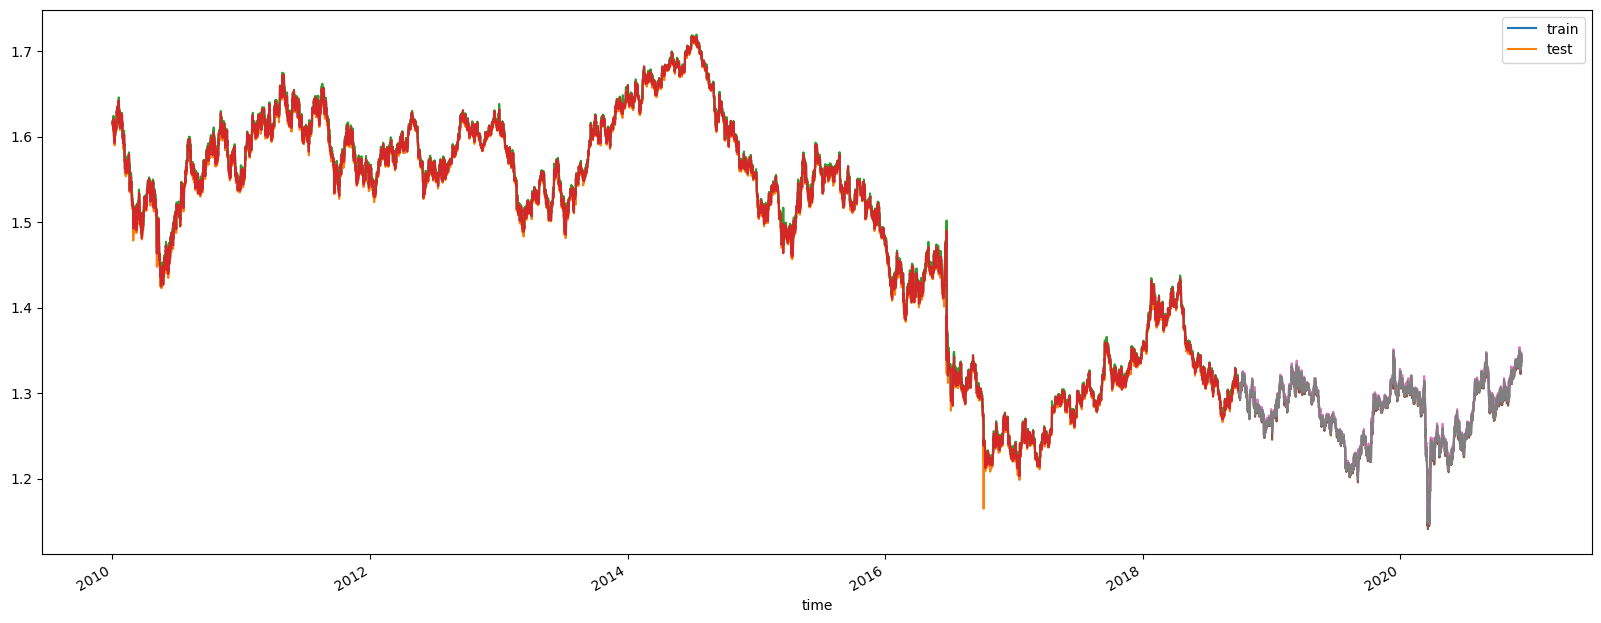

In [76]:
train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot(kind='line',figsize=(20,8))
test.plot(ax=ax,kind='line',figsize=(20,8))
plt.legend(['train', 'test'])

In [77]:
from sklearn.preprocessing import MinMaxScaler

In [78]:
sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)


In [79]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [80]:
timesteps = 6

# Create the training data
X = []
y = []
for i in range(timesteps, X_train.shape[0]):
    X.append(train_sc[i-timesteps:i])
    y.append(train_sc[i, 3])
X, y = np.array(X), np.array(y)

print(X.shape)
print(y.shape)


(13610, 6, 4)
(13610,)


In [85]:
K.clear_session()


model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(6, 4)),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation ='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=1, activation='linear')
])

In [86]:
model_lstm.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
#there may be a potiental error in this, change y_train???
history_model_lstm = model_lstm.fit(X, y, epochs=100, batch_size=192, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
71/71 [==============================] - 3s 12ms/step - loss: 0.0692 - rmse: 0.2631
Epoch 2/100
71/71 [==============================] - 1s 13ms/step - loss: 0.0450 - rmse: 0.2121
Epoch 3/100
71/71 [==============================] - 1s 13ms/step - loss: 0.0389 - rmse: 0.1971
Epoch 4/100
71/71 [==============================] - 1s 13ms/step - loss: 0.0475 - rmse: 0.2179
Epoch 5/100
71/71 [==============================] - 1s 13ms/step - loss: 0.0572 - rmse: 0.2391
Epoch 6/100
71/71 [==============================] - 1s 14ms/step - loss: 0.0724 - rmse: 0.2690
Epoch 7/100
71/71 [==============================] - 1s 16ms/step - loss: 0.0682 - rmse: 0.2612
Epoch 8/100
71/71 [==============================] - 1s 13ms/step - loss: 0.0526 - rmse: 0.2294
Epoch 8: early stopping


In [90]:
#this needs work your future iterarations are currently using 4 prices to predict the closing price, but the model requires 4 inputs.
#We need to either change the y_train so it takes in 4 prices aswell.   





X_test_lstm = []
Y_test_lstm = []

for i in range(timesteps, test.shape[0]):
    X_test_lstm.append(test_sc[i-timesteps:i])
    Y_test_lstm.append(test_sc[i, 3])

    
X_test_lstm = np.array(X_test_lstm)
Y_test_lstm = np.array(Y_test_lstm)

print(X_test_lstm.shape)
print(Y_test_lstm.shape)

y_pred_test_lstm = model_lstm.predict(X_test_lstm)












(3399, 6, 4)
(3399,)
107/107 [==============================] - 0s 2ms/step


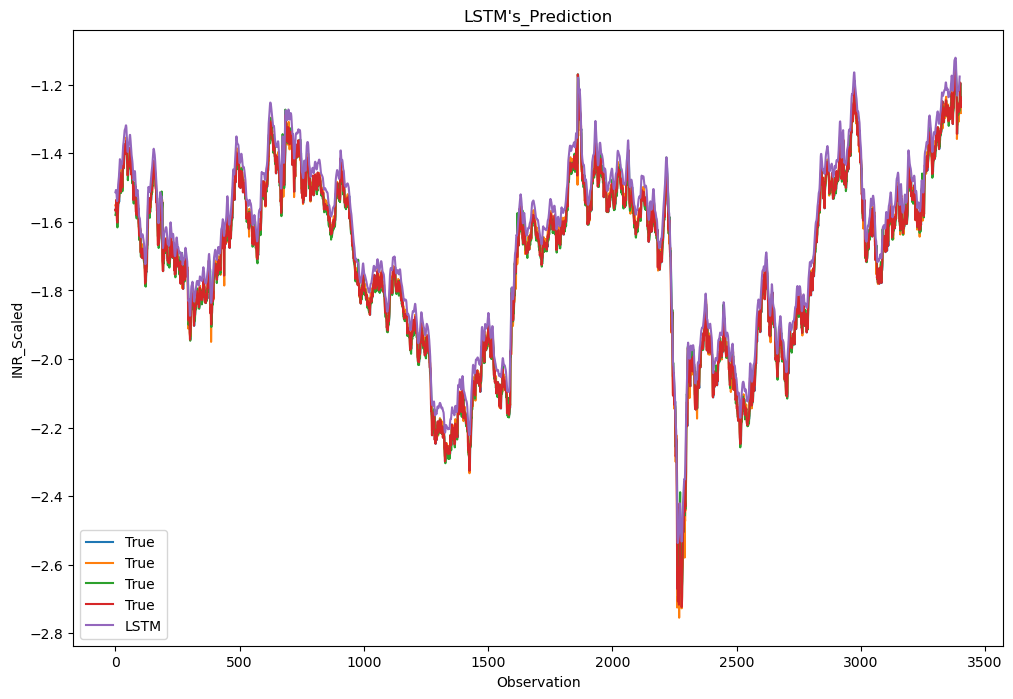

In [88]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [104]:




future_predictions = []

# Get the last sequence from the test data
last_sequence = y_pred_test_lstm[-timesteps:] 
print(last_sequence.shape)

for i in range(10):
    # make a prediction using the last_six array
    pred = model_lstm.predict(last_sequence.reshape(1, 6, 1))
    # append the prediction to the end of last_six
    last_six = np.vstack([last_sequence, pred])
    # remove the first element to maintain window size of 6
    last_sequence = last_sequence[1:]
    future_predictions.append(pred)


# Print the future predictions
print("Future Predictions:")
print(future_predictions)







(6, 1)


InvalidArgumentError: Graph execution error:

Specified a list with shape [?,4] from a tensor with shape [1,1]
	 [[{{node TensorArrayUnstack/TensorListFromTensor}}]]
	 [[sequential/lstm/PartitionedCall]] [Op:__inference_predict_function_56145]

In [98]:
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc



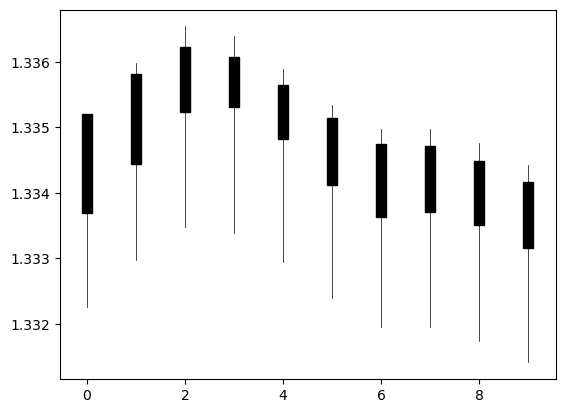

In [67]:

date_strings = ['2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16', '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20', '2023-04-21', '2023-04-22']


# Convert date strings to DatetimeIndex
dates = pd.to_datetime(date_strings)

# Combine data into a DataFrame
data = pd.DataFrame({'Open': ope, 'High': high, 'Low': low, 'Close': close}, index=dates)

# Convert index to DatetimeIndex (if needed)
data.index = pd.to_datetime(data.index)

# Create plot
fig, ax = plt.subplots()
candlestick_ohlc(ax, zip(range(len(data)), data['Open'], data['High'], data['Low'], data['Close']))

plt.show()